In [1]:
from time import perf_counter
import os
from joblib import Parallel, delayed
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt

from src import utils
from src import models

SEED = 10
N_CPUS = os.cpu_count()

np.random.seed(SEED)

In [2]:
def run_experiment(g, Exps, graph_p, signal_p, def_args, verb=True, compute_all_errs=True):
    n_adjs = len(graph_p['new_nodes']) + 1
    if isinstance(signal_p['samples_t'], list):
        n_samples = np.sum(signal_p['samples_t'])
    else:
        n_samples = signal_p['samples_t']*n_adjs

    n_iters = n_samples #+ n_adjs

    err_seq = np.zeros((n_iters, len(Exps)))
    runtime = np.zeros(len(Exps))
    err_graphs = None
    err_first = None
    if compute_all_errs:
        err_graphs = np.zeros((n_adjs, len(Exps)))
        err_first = np.zeros_like(err_graphs)
    
    for i, exp in enumerate(Exps):
        graph_p_aux = {**graph_p, **exp['graph_p']} if 'graph_p' in exp.keys() else {**graph_p}
        sig_p_aux = {**signal_p, **exp['sig_p']} if 'sig_p' in exp.keys() else {**signal_p}

        Adj_list = utils.create_dinamic_graph(**graph_p_aux)
        X_list, _ = utils.create_dinamic_gmrf_signals(Adj_list, **sig_p_aux)

        n_nodes = Adj_list[-1].shape[0]
        n_samples_aux = np.array( [X_i.shape[1] for X_i in X_list] ).sum()
        
        assert n_samples == n_samples_aux, f'samples dont match!! {n_samples_aux}' 

        args_aux = {**def_args, **exp['args']} if 'args' in exp.keys() else {**def_args}
        args_aux['lamb'] = utils.lamb_value(n_nodes, n_samples, args_aux['lamb'])
        model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
        t_init = perf_counter()
        model.fit(X_list, **args_aux)
        t_end = perf_counter()

        err_seq[:,i] = model.test_sequence_err(Adj_list)
        runtime[i] = t_end - t_init
        err_graph_aux = model.test_err(Adj_list)
        err_first_aux = model.test_err_graph_i(Adj_list, 0)

        if compute_all_errs:
            err_graphs[:,i] = err_graph_aux
            err_first[:,i] = err_first_aux

        if verb and g % N_CPUS == 0:
            print(f'- {g+1}. {exp["leg"]}: Err 1st graph: {err_first_aux[-1]:.3f}   -   Err last graph: {err_graph_aux[-1]:.3f}   ' +\
                  f'-   time: {runtime[i]:.3f} secs')            

    return err_graphs, err_seq, err_first, runtime

def plot_results(exps, err_graphs, err_seq, err_first, graph_p, agg='mean'):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Compute growing number of nodes
    graph_dims = np.ones(len(graph_p['new_nodes']) + 1) * graph_p['n_nodes']
    for i, new_nodes in enumerate(graph_p['new_nodes']):
        graph_dims[i+1] = graph_dims[i] + new_nodes

    utils.plot_data(axes[0], err_graphs, exps, graph_dims, 'Number of nodes', 'Error growing graph',
                    agg=agg, deviation='prctile')
    utils.plot_data(axes[1], err_first, exps, graph_dims, 'Number of nodes', 'Error 1st block',
                    agg=agg, deviation='prctile')
    utils.plot_data(axes[2], err_seq, exps, np.arange(err_seq[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg=agg, deviation='prctile')
    plt.tight_layout()


# Magnitud of incoming nodes

In [3]:
# Default experiment parameters and auxiliary funcitons
## Graph parameters
n_graphs = 50
N = 50
verb = True
graph_p = {
    'n_nodes': N,
    'edges': N*4,
    'graph_type': 'er',
    'edge_type': 'positive',
    'new_nodes': [2]*5,
    'new_edges': 4,
    'load_adjs_fact': .05,  # 01
    'conn_nodes': True,
}

## Signal parameters
signal_p = {
    'samples_t': 1000,
    'noise_power': .05,
}

default_args = {
    'iters_sample': 1,
    'lamb': .25, #1e-2,
    'stepsize': 5e-3,
    'gamma': .95, 
    'epsilon': .05,
    'alpha': 0,
}

CPUs employed: 64
- 1. nodes: 1, edgess: 4: Err 1st graph: 0.069   -   Err last graph: 0.075   -   time: 4.067 secs
- 1. nodes: 5, edgess: 4: Err 1st graph: 0.070   -   Err last graph: 0.115   -   time: 5.313 secs
- 1. nodes: 10, edgess: 4: Err 1st graph: 0.063   -   Err last graph: 0.151   -   time: 7.371 secs
- 1. nodes: 25, edgess: 4: Err 1st graph: 0.064   -   Err last graph: 0.204   -   time: 16.867 secs
- 1. nodes: 5, edgess: 8: Err 1st graph: 0.098   -   Err last graph: 0.124   -   time: 3.557 secs
- 1. nodes: 5, edgess: 12: Err 1st graph: 0.130   -   Err last graph: 0.161   -   time: 3.482 secs
----- Solved in 0.769 minutes -----


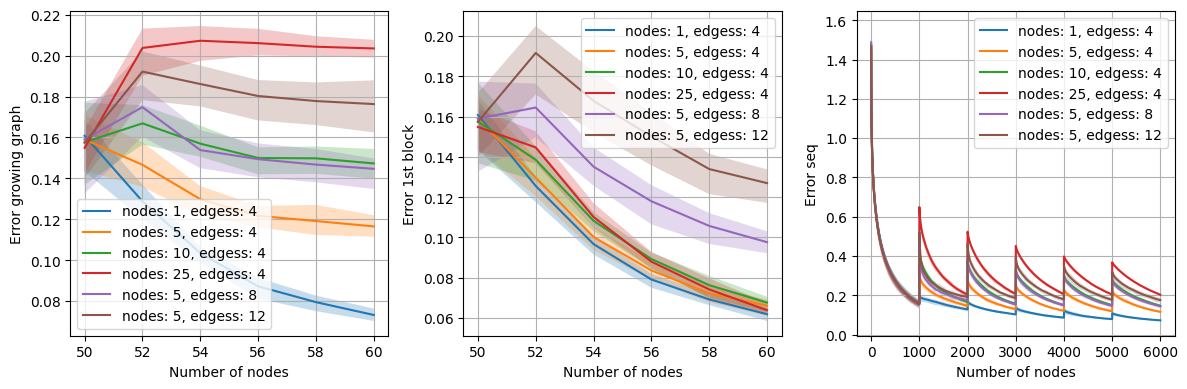

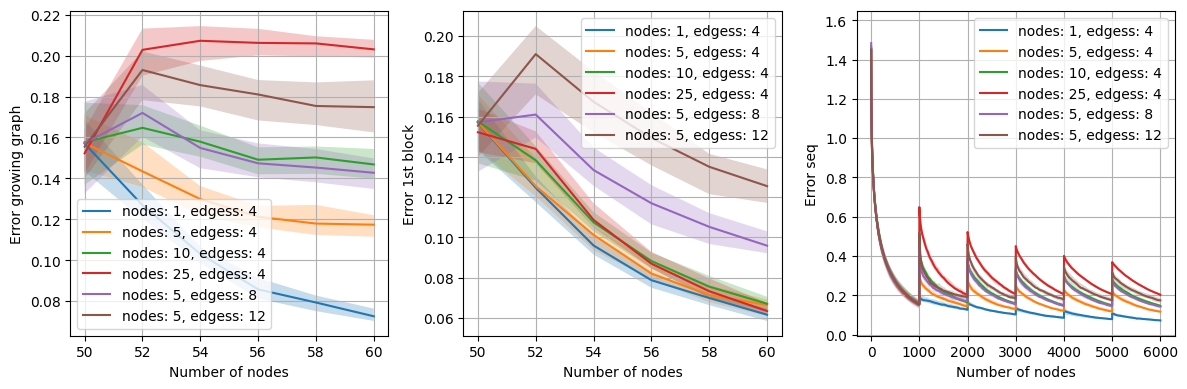

In [4]:
Exps = [
    # {'model': models.Offline_dyn_nti, 'args': {'iters_sample': 10,}, 'leg': 'offline', 'fmt': '-'},
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 
     'graph_p': {'new_nodes': [1]*5, 'new_edges': 4,}, 'leg': 'nodes: 1, edgess: 4', 'fmt': '-'},
    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 
     'graph_p': {'new_nodes': [5]*5, 'new_edges': 4,}, 'leg': 'nodes: 5, edgess: 4', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 
     'graph_p': {'new_nodes': [10]*5, 'new_edges': 4,}, 'leg': 'nodes: 10, edgess: 4', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 
     'graph_p': {'new_nodes': [25]*5, 'new_edges': 4,}, 'leg': 'nodes: 25, edgess: 4', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 
     'graph_p': {'new_nodes': [5]*5, 'new_edges': 8,}, 'leg': 'nodes: 5, edgess: 8', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 
     'graph_p': {'new_nodes': [5]*5, 'new_edges': 12,}, 'leg': 'nodes: 5, edgess: 12', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p, default_args, verb) for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_graphs, err_seq, err_first, runtime = zip(*results)

plot_results(Exps, err_graphs, err_seq, err_first, graph_p)
plot_results(Exps, err_graphs, err_seq, err_first, graph_p, agg='median')

# Frequency incoming nodes

CPUs employed: 64
- 1. 5 every 500, d: Err 1st graph: 0.073   -   Err last graph: 0.154   -   time: 6.424 secs
- 1. 10 every 1000, d: Err 1st graph: 0.068   -   Err last graph: 0.142   -   time: 6.677 secs
- 1. 50 every 5000, d: Err 1st graph: 0.068   -   Err last graph: 0.133   -   time: 6.495 secs
- 1. 50 every 5000, d: Err 1st graph: 0.066   -   Err last graph: 0.090   -   time: 9.811 secs
- 1. 5 every 500: Err 1st graph: 0.070   -   Err last graph: 0.189   -   time: 6.512 secs
- 1. 10 every 1000: Err 1st graph: 0.062   -   Err last graph: 0.138   -   time: 6.739 secs
- 1. 50 every 5000: Err 1st graph: 0.100   -   Err last graph: 0.110   -   time: 6.502 secs
- 1. 50 every 5000: Err 1st graph: 0.101   -   Err last graph: 0.063   -   time: 6.680 secs
----- Solved in 0.979 minutes -----


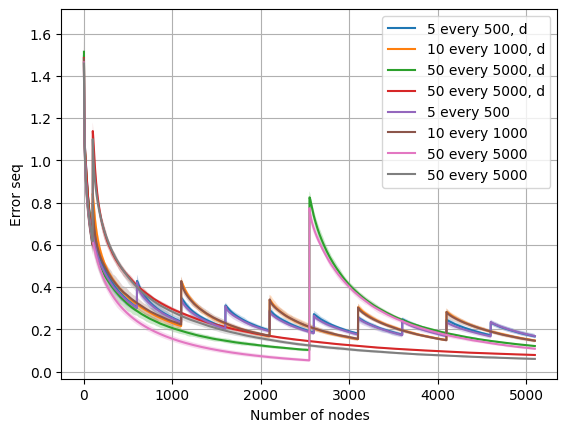

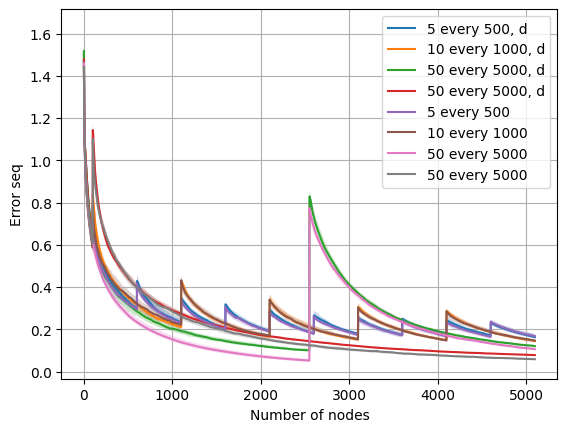

In [5]:
signal_p_aux = signal_p.copy()
signal_p_aux = {
    'samples_t': [100] + [1000]*5,
    'noise_power': .05,
}

Exps = [
    # {'model': models.Offline_dyn_nti, 'args': {'iters_sample': 10,}, 'leg': 'offline', 'fmt': '-'},
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [1]*50},
    #  'sig_p': {'samples_t': 100}, 'leg': '1 every 100', 'fmt': '-'},
    
    # {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [2]*25},
    #  'sig_p': {'samples_t': [100] + [200]*25}, 'leg': '2 every 200', 'fmt': '-'},

    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'graph_p': {'new_nodes': [5]*10},
     'sig_p': {'samples_t': [100] + [500]*10}, 'leg': '5 every 500, d', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'graph_p': {'new_nodes': [10]*5},
     'sig_p': {'samples_t': [100] + [1000]*5}, 'leg': '10 every 1000, d', 'fmt': '-'},
    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'graph_p': {'new_nodes': [50]},
     'sig_p': {'samples_t': [2550] + [2550]}, 'leg': '50 every 5000, d', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'dynamic'}, 'graph_p': {'new_nodes': [50]},
     'sig_p': {'samples_t': [100] + [5000]}, 'leg': '50 every 5000, d', 'fmt': '-'},

    
    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [5]*10},
     'sig_p': {'samples_t': [100] + [500]*10}, 'leg': '5 every 500', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [10]*5},
     'sig_p': {'samples_t': [100] + [1000]*5}, 'leg': '10 every 1000', 'fmt': '-'},
    
    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [50]},
     'sig_p': {'samples_t': [2550] + [2550]}, 'leg': '50 every 5000', 'fmt': '-'},

    {'model': models.Online_dyn_nti, 'init': {'cov_update': 'incr'}, 'graph_p': {'new_nodes': [50]},
     'sig_p': {'samples_t': [100] + [5000]}, 'leg': '50 every 5000', 'fmt': '-'},
]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_experiment)(g, Exps, graph_p, signal_p_aux, default_args, verb, False) \
                                  for g in range(n_graphs))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

err_graphs, err_seq, err_first, runtime = zip(*results)

fig, axes = plt.subplots()
utils.plot_data(axes, err_seq, Exps, np.arange(err_seq[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='mean', deviation='prctile')
fig, axes = plt.subplots()
utils.plot_data(axes, err_seq, Exps, np.arange(err_seq[0].shape[0]), 'Number of nodes', 'Error seq',
                    agg='median', deviation='prctile')

